In [1]:
!pip install deepctr-torch
!pip install lightgbm
!pip install optuna

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 82 kB 697 kB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 348 kB 31.5 MB/s 
     |████████████████████████████████| 81 kB 8.8 MB/s 
     |████████████████████████████████| 209 kB 78.2 MB/s 
     |████████████████████████████████| 78 kB 7.0 MB/s 
     |████████████████████████████████| 147 kB 9.5 MB/s 
     |████████████████████████████████| 50 kB 5.6 MB/s 
     |████████████████████████████████| 112 kB 58.7 MB/s 
  Created wheel for pyperclip: filename=pyperclip-1.8.2-py3-none-any.whl size=11136 sha256=54982db000cf4680477cad96c4e6b65b4182fd828b69199d31222bdf141b4b2d
  Stored in directory: /root/.cache/pip/wheels/7f/1a/65/84ff8c386bec21fca6d220ea1f5498a03678

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


데이터 압축 풀기

In [3]:
import os
os.chdir('/content/drive/MyDrive/YDS/AIConnect_YDS_2')

In [ ]:
# rm -rf Train

In [ ]:
# !unzip train.zip

In [4]:
import pandas as pd
import torch
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder,MultiLabelBinarizer,MinMaxScaler
import matplotlib.pyplot as plt
from deepctr_torch.inputs import SparseFeat, get_feature_names, DenseFeat
from deepctr_torch.models import DeepFM
from sklearn.metrics import mean_absolute_error
import numpy as np
from lightgbm import LGBMRegressor,plot_importance,Dataset

In [5]:
# Main Train 파일 로드
Ori_Train = pd.read_csv('./Train/Train.csv', encoding='utf-8')

In [6]:
# 엑셀파일이기에 read_excel로 로드
Sub_Data = pd.read_excel('./Train/ETC_Data/Main_Subjects.xlsx')

In [7]:
test = pd.read_csv('Test.csv')

In [ ]:
# Basic = pd.read_excel('Train/ETC_Data/Basic.xlsx')
# Detail_Info = pd.read_excel('Train/ETC_Data/Detail_Info.xlsx')
# Main_Subjects = pd.read_excel('Train/ETC_Data/Main_Subjects.xlsx')
# Medical_Facility = pd.read_excel('Train/ETC_Data/Medical_Facility.xlsx')
# Reception_Reservation_Days = pd.read_csv('Train/ETC_Data/Reception_Reservation_Days_2022.CSV',encoding='utf-8')
# Transportation = pd.read_excel('Train/ETC_Data/Transportation.xlsx')

In [ ]:
# Ori_Train

Question_ID = USER_ID + HOSPITAL_ID = Identity_ID

In [8]:
submission = pd.read_csv('Sample_Submission.csv')
submission = submission.drop(columns = ['Unnamed: 0'])

In [ ]:
# Ori_Train.loc[Ori_Train['Identity_Key'] == '201020684119_33732']

,Unnamed: 0,USER_ID,REG_DATE,TOTAL_RATE,TX_RATE,SERVICE_RATE,ETC_RATE,CONTENTS,HOSPITAL_CD,HOSPITAL_NM,...,시도코드명,시군구코드,시군구코드명,전화번호,병원홈페이지(URL),개설일자,총의사수,x좌표,y좌표,Identity_Key


In [45]:
Ori_Train.columns

Index(['Unnamed: 0', 'USER_ID', 'REG_DATE', 'TOTAL_RATE', 'TX_RATE',
       'SERVICE_RATE', 'ETC_RATE', 'CONTENTS', 'HOSPITAL_CD', 'HOSPITAL_NM',
       'ADD', 'HOSPITAL_ID', 'TIME', '요양기관명', '종별코드', '종별코드명', '시도코드', '시도코드명',
       '시군구코드', '시군구코드명', '전화번호', '병원홈페이지(URL)', '개설일자', '총의사수', 'x좌표', 'y좌표',
       'Identity_Key'],
      dtype='object')

In [ ]:
# Sub_Data['진료과목코드명'].value_counts()[:-10]

In [ ]:
# Sub_Data.loc[Sub_Data['암호화요양기호'] == 'JDQ4MTYyMiM1MSMkMSMkNCMkOTIkMzgxOTYxIzExIyQxIyQzIyQ4OSQ0NjE0ODEjNjEjJDEjJDgjJDgz']

# Sub_Data.loc[Sub_Data['요양기관명'].str.contains('치')]
# Sub_Data['진료과목코드명'].value_counts()

In [ ]:
Sub_Data['진료과목코드명'].value_counts()

내과              23320
피부과             16596
한방내과            16511
소아청소년과          15462
침구과             14820
한방부인과           14459
한방소아과           14180
한방안·이비인후·피부과    13889
한방신경정신과         13378
한방재활의학과         12657
이비인후과           12195
정형외과            11839
사상체질과           11737
치과              10989
가정의학과            9597
외과               9298
치과보철과            8646
치주과              8453
치과보존과            8215
비뇨의학과            8183
소아치과             8105
구강악안면외과          8099
예방치과             7576
구강내과             7542
치과교정과            7434
마취통증의학과          7242
신경외과             7124
영상치의학과           6654
재활의학과            6631
신경과              5402
구강병리과            5116
성형외과             4919
안과               4381
산부인과             4231
영상의학과            3741
정신건강의학과          3560
통합치의학과           2541
한방응급             1589
진단검사의학과          1518
흉부외과             1122
병리과              1011
응급의학과             834
직업환경의학과           424
예방의학과             395
결핵과               317
방사선종양학과   

In [9]:
# Primary Key 별로 진료과목 정리

Sub_Data = Sub_Data.groupby(['암호화요양기호'])['진료과목코드명'].apply(','.join).reset_index()
Sub_Data

,암호화요양기호,진료과목코드명
0,JDQ4MTAxMiM1MSMkMSMkMCMkMTMkMzgxMTkxIzExIyQxIy...,"내과,산부인과,비뇨의학과,가정의학과,한방내과,한방부인과,한방소아과,한방안·이비인후·..."
1,JDQ4MTAxMiM1MSMkMSMkMCMkMTMkMzgxMTkxIzExIyQxIy...,"재활의학과,한방내과,한방부인과,한방소아과,한방안·이비인후·피부과,한방신경정신과,침구..."
2,JDQ4MTAxMiM1MSMkMSMkMCMkMTMkMzgxMTkxIzExIyQxIy...,"영상의학과,한방내과,한방안·이비인후·피부과,한방신경정신과,침구과,한방재활의학과"
3,JDQ4MTAxMiM1MSMkMSMkMCMkMTMkMzgxMTkxIzExIyQxIy...,"재활의학과,한방내과,한방부인과,한방소아과,한방안·이비인후·피부과,한방신경정신과,침구..."
4,JDQ4MTAxMiM1MSMkMSMkMCMkMTMkMzgxMTkxIzExIyQxIy...,"정형외과,한방내과,한방부인과,한방소아과,한방안·이비인후·피부과,한방신경정신과,침구과..."
...,...,...
72583,JDU4MTI3MSM1MSMkMiMkMCMkMDAkNTgxMzUxIzIxIyQyIy...,"성형외과,산부인과,피부과,가정의학과"
72584,JDU4MTI3MSM1MSMkMiMkMCMkMDAkNTgxMzUxIzIxIyQyIy...,"내과,소아청소년과,이비인후과,피부과,비뇨의학과,가정의학과"
72585,JDU4MTI3MSM1MSMkMiMkMCMkMDAkNTgxMzUxIzIxIyQyIy...,"피부과,가정의학과"
72586,JDU4MTI3MSM1MSMkMiMkMCMkMDAkNTgxMzUxIzIxIyQyIy...,이비인후과


In [ ]:
Sub_Data.value_counts()[:50]

암호화요양기호                                                                           진료과목코드명                                                                    
JDQ4MTAxMiM1MSMkMSMkMCMkMTMkMzgxMTkxIzExIyQxIyQzIyQ2MiQ0NjE0ODEjNjEjJDEjJDgjJDgz  내과,산부인과,비뇨의학과,가정의학과,한방내과,한방부인과,한방소아과,한방안·이비인후·피부과,한방신경정신과,침구과,한방재활의학과,사상체질과    1
JDQ4MTg4MSM1MSMkMSMkMCMkMTMkNDgxOTYxIzUxIyQxIyQ1IyQxMyQ0NjE0ODEjNTEjJDEjJDYjJDgz  한방내과,한방부인과,한방소아과,한방안·이비인후·피부과,한방신경정신과,침구과,한방재활의학과,사상체질과                        1
JDQ4MTg4MSM1MSMkMSMkMCMkMTMkNDgxOTYxIzUxIyQxIyQxIyQ2MiQzNjEyMjIjNjEjJDEjJDAjJDgz  한방내과,한방부인과,한방소아과,한방안·이비인후·피부과,한방신경정신과,침구과,한방재활의학과,사상체질과,한방응급                   1
JDQ4MTg4MSM1MSMkMSMkMCMkMTMkNDgxOTYxIzUxIyQxIyQxIyQ2MiQyNjEyMjIjNDEjJDEjJDgjJDgz  한방내과,한방부인과,한방소아과,한방안·이비인후·피부과,한방신경정신과,침구과,한방재활의학과,사상체질과                        1
JDQ4MTg4MSM1MSMkMSMkMCMkMTMkNDgxOTYxIzUxIyQxIyQxIyQ2MiQyNjEwMDIjNTEjJDEjJDYjJDgz  한방내과,한방부인과,한방소아과,한방안·이비인후·피부과,한방신경정신과,침구과,한방재활의학과,사상체질과                        1
JDQ4MTg4MSM1MSMkMSMkMCMkMTM

In [10]:
# 오름차순 정렬
Sub_Data['진료과목코드명'] = Sub_Data['진료과목코드명'].apply(lambda x: sorted(set(x.split(','))))
Sub_Data

,암호화요양기호,진료과목코드명
0,JDQ4MTAxMiM1MSMkMSMkMCMkMTMkMzgxMTkxIzExIyQxIy...,"[가정의학과, 내과, 비뇨의학과, 사상체질과, 산부인과, 침구과, 한방내과, 한방부..."
1,JDQ4MTAxMiM1MSMkMSMkMCMkMTMkMzgxMTkxIzExIyQxIy...,"[사상체질과, 재활의학과, 침구과, 한방내과, 한방부인과, 한방소아과, 한방신경정신..."
2,JDQ4MTAxMiM1MSMkMSMkMCMkMTMkMzgxMTkxIzExIyQxIy...,"[영상의학과, 침구과, 한방내과, 한방신경정신과, 한방안·이비인후·피부과, 한방재활..."
3,JDQ4MTAxMiM1MSMkMSMkMCMkMTMkMzgxMTkxIzExIyQxIy...,"[사상체질과, 재활의학과, 침구과, 한방내과, 한방부인과, 한방소아과, 한방신경정신..."
4,JDQ4MTAxMiM1MSMkMSMkMCMkMTMkMzgxMTkxIzExIyQxIy...,"[사상체질과, 정형외과, 침구과, 한방내과, 한방부인과, 한방소아과, 한방신경정신과..."
...,...,...
72583,JDU4MTI3MSM1MSMkMiMkMCMkMDAkNTgxMzUxIzIxIyQyIy...,"[가정의학과, 산부인과, 성형외과, 피부과]"
72584,JDU4MTI3MSM1MSMkMiMkMCMkMDAkNTgxMzUxIzIxIyQyIy...,"[가정의학과, 내과, 비뇨의학과, 소아청소년과, 이비인후과, 피부과]"
72585,JDU4MTI3MSM1MSMkMiMkMCMkMDAkNTgxMzUxIzIxIyQyIy...,"[가정의학과, 피부과]"
72586,JDU4MTI3MSM1MSMkMiMkMCMkMDAkNTgxMzUxIzIxIyQyIy...,[이비인후과]


In [11]:
# Data Merge
Merged_Train = pd.merge(Ori_Train,Sub_Data,left_on='HOSPITAL_CD',right_on='암호화요양기호',how='left')
Merged_Train

,Unnamed: 0,USER_ID,REG_DATE,TOTAL_RATE,TX_RATE,SERVICE_RATE,ETC_RATE,CONTENTS,HOSPITAL_CD,HOSPITAL_NM,...,시군구코드명,전화번호,병원홈페이지(URL),개설일자,총의사수,x좌표,y좌표,Identity_Key,암호화요양기호,진료과목코드명
0,0,4.778650e+05,2018-07-23 09:24:08,9.0,8.0,10.0,8.0,볼지방제거와 밴드리프팅 한지 한달됐어요 많이 가름해졌어요 좀더 지켜봐야 할것같다,JDQ4MTg4MSM1MSMkMiMkNCMkMDAkNDgxMzUxIzMxIyQxIy...,리팅성형외과의원,...,강남구,1899-9717,http://www.yonseiplus.com,2016-09-07 00:00:00,25,127.020169,37.515876,477865_85156,JDQ4MTg4MSM1MSMkMiMkNCMkMDAkNDgxMzUxIzMxIyQxIy...,[성형외과]
1,1,2.010333e+11,2018-07-23 09:59:15,10.0,10.0,10.0,10.0,너무좋은데. 아직 좀지켜봐야알겠지만 예뻐질것같은 느낌이예요,JDQ4MTg4MSM1MSMkMiMkNCMkMDAkNDgxMzUxIzMxIyQxIy...,리팅성형외과의원,...,강남구,1899-9717,http://www.yonseiplus.com,2016-09-07 00:00:00,25,127.020169,37.515876,201033325523_85156,JDQ4MTg4MSM1MSMkMiMkNCMkMDAkNDgxMzUxIzMxIyQxIy...,[성형외과]
2,2,3.381810e+05,2018-07-23 10:00:57,10.0,10.0,10.0,10.0,꼭당첨!!!,JDQ4MTg4MSM1MSMkMiMkNCMkMDAkNDgxMzUxIzMxIyQxIy...,리팅성형외과의원,...,강남구,1899-9717,http://www.yonseiplus.com,2016-09-07 00:00:00,25,127.020169,37.515876,338181_85156,JDQ4MTg4MSM1MSMkMiMkNCMkMDAkNDgxMzUxIzMxIyQxIy...,[성형외과]
3,3,2.010326e+11,2018-07-24 12:57:55,5.0,6.0,6.0,4.0,무제한 보톡스 는 아닌것 같아요 보톡스를 맞기 위한 옷 이 없어 기다림 남이 입건것...,JDQ4MTg4MSM1MSMkMiMkNCMkMDAkNDgxMzUxIzMxIyQxIy...,리팅성형외과의원,...,강남구,1899-9717,http://www.yonseiplus.com,2016-09-07 00:00:00,25,127.020169,37.515876,201032630325_85156,JDQ4MTg4MSM1MSMkMiMkNCMkMDAkNDgxMzUxIzMxIyQxIy...,[성형외과]
4,4,4.998490e+05,2018-07-25 10:08:18,10.0,10.0,10.0,10.0,NaN,JDQ4MTg4MSM1MSMkMiMkNCMkMDAkNDgxMzUxIzMxIyQxIy...,리팅성형외과의원,...,강남구,1899-9717,http://www.yonseiplus.com,2016-09-07 00:00:00,25,127.020169,37.515876,499849_85156,JDQ4MTg4MSM1MSMkMiMkNCMkMDAkNDgxMzUxIzMxIyQxIy...,[성형외과]
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48433,167863,2.440542e+06,2022-09-25 04:32:05.963774,8.0,6.0,10.0,10.0,시설 좋고 선생님도 젊으세요 대신 사람이 많아서 그만큼 많이 기다려야해요 수액 놓는...,JDQ4MTg4MSM1MSMkMiMkNCMkMDAkNTgxOTYxIzUxIyQxIy...,벗이비인후과의원,...,광진구,02-6953-5805,NaN,2021-04-12 00:00:00,1,127.071848,37.534118,2440542_72069,JDQ4MTg4MSM1MSMkMiMkNCMkMDAkNTgxOTYxIzUxIyQxIy...,"[내과, 소아청소년과, 신경과, 이비인후과]"
48434,167864,1.658243e+06,2022-09-27 01:22:27.485015,6.0,6.0,6.0,6.0,소이과 되어있어서 왔는데 소아과가 없대서 아가인고 돌아갑니다 ㅜㅜ,JDQ4MTg4MSM1MSMkMiMkMCMkMDAkNDgxNzAyIzExIyQxIy...,전영수내과의원,...,금천구,02-859-3500,NaN,1995-06-17 00:00:00,1,126.905218,37.479841,1658243_73445,JDQ4MTg4MSM1MSMkMiMkMCMkMDAkNDgxNzAyIzExIyQxIy...,"[내과, 소아청소년과]"
48435,167865,2.445760e+06,2022-09-27 05:42:37.378565,10.0,10.0,10.0,10.0,좋은말씀 많이해주세요,JDQ4MTg4MSM1MSMkMiMkOCMkMDAkMzgxMzUxIzIxIyQxIy...,마음담은정신건강의학과의원,...,중랑구,02-2038-3070,NaN,2022-04-20 00:00:00,1,NaN,NaN,2445760_79673,JDQ4MTg4MSM1MSMkMiMkOCMkMDAkMzgxMzUxIzIxIyQxIy...,[정신건강의학과]
48436,167866,2.452015e+06,2022-10-02 02:04:41.373758,10.0,10.0,10.0,10.0,명의이십니다 보통 한의원과는 차원이 달라요 아토피 정신과 허리 치료 받았습니다,JDQ4MTg4MSM1MSMkMSMkMCMkMTMkNDgxMTkxIzUxIyQxIy...,다스름한의원,...,서초구,02-529-7522,NaN,2019-02-07 00:00:00,1,127.070530,37.456457,2452015_25306,JDQ4MTg4MSM1MSMkMSMkMCMkMTMkNDgxMTkxIzUxIyQxIy...,"[사상체질과, 침구과, 한방내과, 한방부인과, 한방소아과, 한방신경정신과, 한방안·..."


In [ ]:
# 서울민트치과의원에 대한 정보가 없다. 즉, Sub_Data에 서울민트치과의원에 대한 정보가 없다는 것
Merged_Train[Merged_Train['진료과목코드명'].isna()]

# df[df.column.isna( )]

,Unnamed: 0,USER_ID,REG_DATE,TOTAL_RATE,TX_RATE,SERVICE_RATE,ETC_RATE,CONTENTS,HOSPITAL_CD,HOSPITAL_NM,...,시군구코드명,전화번호,병원홈페이지(URL),개설일자,총의사수,x좌표,y좌표,Identity_Key,암호화요양기호,진료과목코드명


In [ ]:
# 서울민트치과의원 병원코드 추출
Merged_Train.iloc[48050].HOSPITAL_CD

'JDQ4MTg4MSM1MSMkMSMkMCMkNjIkMzgxMzUxIzExIyQxIyQ3IyQ4MiQ0NjE0ODEjNDEjJDEjJDgjJDgz'

In [ ]:
# Sub_Data에 없는 것 확인
Sub_Data.loc[Sub_Data['암호화요양기호'] == 'JDQ4MTg4MSM1MSMkMSMkMCMkNjIkMzgxMzUxIzExIyQxIyQ3IyQ4MiQ0NjE0ODEjNDEjJDEjJDgjJDgz']

,암호화요양기호,진료과목코드명


In [12]:
# Na값 처리
Merged_Train.dropna(subset=['진료과목코드명'], inplace=True)
# Merged_Train.loc[Merged_Train['진료과목코드명']=='X']

In [ ]:
Merged_Train

,Unnamed: 0,USER_ID,REG_DATE,TOTAL_RATE,TX_RATE,SERVICE_RATE,ETC_RATE,CONTENTS,HOSPITAL_CD,HOSPITAL_NM,...,시군구코드명,전화번호,병원홈페이지(URL),개설일자,총의사수,x좌표,y좌표,Identity_Key,암호화요양기호,진료과목코드명
0,0,4.778650e+05,2018-07-23 09:24:08,9.0,8.0,10.0,8.0,볼지방제거와 밴드리프팅 한지 한달됐어요 많이 가름해졌어요 좀더 지켜봐야 할것같다,JDQ4MTg4MSM1MSMkMiMkNCMkMDAkNDgxMzUxIzMxIyQxIy...,리팅성형외과의원,...,강남구,1899-9717,http://www.yonseiplus.com,2016-09-07 00:00:00,25,127.020169,37.515876,477865_85156,JDQ4MTg4MSM1MSMkMiMkNCMkMDAkNDgxMzUxIzMxIyQxIy...,[성형외과]
1,1,2.010333e+11,2018-07-23 09:59:15,10.0,10.0,10.0,10.0,너무좋은데. 아직 좀지켜봐야알겠지만 예뻐질것같은 느낌이예요,JDQ4MTg4MSM1MSMkMiMkNCMkMDAkNDgxMzUxIzMxIyQxIy...,리팅성형외과의원,...,강남구,1899-9717,http://www.yonseiplus.com,2016-09-07 00:00:00,25,127.020169,37.515876,201033325523_85156,JDQ4MTg4MSM1MSMkMiMkNCMkMDAkNDgxMzUxIzMxIyQxIy...,[성형외과]
2,2,3.381810e+05,2018-07-23 10:00:57,10.0,10.0,10.0,10.0,꼭당첨!!!,JDQ4MTg4MSM1MSMkMiMkNCMkMDAkNDgxMzUxIzMxIyQxIy...,리팅성형외과의원,...,강남구,1899-9717,http://www.yonseiplus.com,2016-09-07 00:00:00,25,127.020169,37.515876,338181_85156,JDQ4MTg4MSM1MSMkMiMkNCMkMDAkNDgxMzUxIzMxIyQxIy...,[성형외과]
3,3,2.010326e+11,2018-07-24 12:57:55,5.0,6.0,6.0,4.0,무제한 보톡스 는 아닌것 같아요 보톡스를 맞기 위한 옷 이 없어 기다림 남이 입건것...,JDQ4MTg4MSM1MSMkMiMkNCMkMDAkNDgxMzUxIzMxIyQxIy...,리팅성형외과의원,...,강남구,1899-9717,http://www.yonseiplus.com,2016-09-07 00:00:00,25,127.020169,37.515876,201032630325_85156,JDQ4MTg4MSM1MSMkMiMkNCMkMDAkNDgxMzUxIzMxIyQxIy...,[성형외과]
4,4,4.998490e+05,2018-07-25 10:08:18,10.0,10.0,10.0,10.0,NaN,JDQ4MTg4MSM1MSMkMiMkNCMkMDAkNDgxMzUxIzMxIyQxIy...,리팅성형외과의원,...,강남구,1899-9717,http://www.yonseiplus.com,2016-09-07 00:00:00,25,127.020169,37.515876,499849_85156,JDQ4MTg4MSM1MSMkMiMkNCMkMDAkNDgxMzUxIzMxIyQxIy...,[성형외과]
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48433,167863,2.440542e+06,2022-09-25 04:32:05.963774,8.0,6.0,10.0,10.0,시설 좋고 선생님도 젊으세요 대신 사람이 많아서 그만큼 많이 기다려야해요 수액 놓는...,JDQ4MTg4MSM1MSMkMiMkNCMkMDAkNTgxOTYxIzUxIyQxIy...,벗이비인후과의원,...,광진구,02-6953-5805,NaN,2021-04-12 00:00:00,1,127.071848,37.534118,2440542_72069,JDQ4MTg4MSM1MSMkMiMkNCMkMDAkNTgxOTYxIzUxIyQxIy...,"[내과, 소아청소년과, 신경과, 이비인후과]"
48434,167864,1.658243e+06,2022-09-27 01:22:27.485015,6.0,6.0,6.0,6.0,소이과 되어있어서 왔는데 소아과가 없대서 아가인고 돌아갑니다 ㅜㅜ,JDQ4MTg4MSM1MSMkMiMkMCMkMDAkNDgxNzAyIzExIyQxIy...,전영수내과의원,...,금천구,02-859-3500,NaN,1995-06-17 00:00:00,1,126.905218,37.479841,1658243_73445,JDQ4MTg4MSM1MSMkMiMkMCMkMDAkNDgxNzAyIzExIyQxIy...,"[내과, 소아청소년과]"
48435,167865,2.445760e+06,2022-09-27 05:42:37.378565,10.0,10.0,10.0,10.0,좋은말씀 많이해주세요,JDQ4MTg4MSM1MSMkMiMkOCMkMDAkMzgxMzUxIzIxIyQxIy...,마음담은정신건강의학과의원,...,중랑구,02-2038-3070,NaN,2022-04-20 00:00:00,1,NaN,NaN,2445760_79673,JDQ4MTg4MSM1MSMkMiMkOCMkMDAkMzgxMzUxIzIxIyQxIy...,[정신건강의학과]
48436,167866,2.452015e+06,2022-10-02 02:04:41.373758,10.0,10.0,10.0,10.0,명의이십니다 보통 한의원과는 차원이 달라요 아토피 정신과 허리 치료 받았습니다,JDQ4MTg4MSM1MSMkMSMkMCMkMTMkNDgxMTkxIzUxIyQxIy...,다스름한의원,...,서초구,02-529-7522,NaN,2019-02-07 00:00:00,1,127.070530,37.456457,2452015_25306,JDQ4MTg4MSM1MSMkMSMkMCMkMTMkNDgxMTkxIzUxIyQxIy...,"[사상체질과, 침구과, 한방내과, 한방부인과, 한방소아과, 한방신경정신과, 한방안·..."


In [13]:
# Muliti Label Onehot
mlb = MultiLabelBinarizer()
Encoded_Value = mlb.fit_transform(Merged_Train['진료과목코드명'])
Hospital_Class = mlb.classes_
Hospital_Class = ['진료과목'+'_'+ k for k in Hospital_Class]
One_Hot_Classes = pd.DataFrame(Encoded_Value, columns = Hospital_Class)
Merged_Train = Merged_Train.drop('진료과목코드명',axis=1)

Refined_Train = pd.concat([Merged_Train, One_Hot_Classes],axis=1)

In [ ]:
mlb.classes_

array(['가정의학과', '결핵과', '구강내과', '구강병리과', '구강악안면외과', '내과', '마취통증의학과',
       '방사선종양학과', '병리과', '비뇨기과', '비뇨의학과', '사상체질과', '산부인과', '성형외과',
       '소아청소년과', '소아치과', '신경과', '신경외과', '안과', '영상의학과', '영상치의학과', '예방의학과',
       '예방치과', '외과', '응급의학과', '이비인후과', '재활의학과', '정신건강의학과', '정형외과',
       '직업환경의학과', '진단검사의학과', '치과', '치과교정과', '치과보존과', '치과보철과', '치주과',
       '침구과', '통합치의학과', '피부과', '한방내과', '한방부인과', '한방소아과', '한방신경정신과',
       '한방안·이비인후·피부과', '한방응급', '한방재활의학과', '핵의학과', '흉부외과'], dtype=object)

In [ ]:
Refined_Train.columns

Index(['Unnamed: 0', 'USER_ID', 'REG_DATE', 'TOTAL_RATE', 'TX_RATE',
       'SERVICE_RATE', 'ETC_RATE', 'CONTENTS', 'HOSPITAL_CD', 'HOSPITAL_NM',
       'ADD', 'HOSPITAL_ID', 'TIME', '요양기관명', '종별코드', '종별코드명', '시도코드', '시도코드명',
       '시군구코드', '시군구코드명', '전화번호', '병원홈페이지(URL)', '개설일자', '총의사수', 'x좌표', 'y좌표',
       'Identity_Key', '암호화요양기호', '진료과목_가정의학과', '진료과목_결핵과', '진료과목_구강내과',
       '진료과목_구강병리과', '진료과목_구강악안면외과', '진료과목_내과', '진료과목_마취통증의학과', '진료과목_방사선종양학과',
       '진료과목_병리과', '진료과목_비뇨기과', '진료과목_비뇨의학과', '진료과목_사상체질과', '진료과목_산부인과',
       '진료과목_성형외과', '진료과목_소아청소년과', '진료과목_소아치과', '진료과목_신경과', '진료과목_신경외과',
       '진료과목_안과', '진료과목_영상의학과', '진료과목_영상치의학과', '진료과목_예방의학과', '진료과목_예방치과',
       '진료과목_외과', '진료과목_응급의학과', '진료과목_이비인후과', '진료과목_재활의학과', '진료과목_정신건강의학과',
       '진료과목_정형외과', '진료과목_직업환경의학과', '진료과목_진단검사의학과', '진료과목_치과', '진료과목_치과교정과',
       '진료과목_치과보존과', '진료과목_치과보철과', '진료과목_치주과', '진료과목_침구과', '진료과목_통합치의학과',
       '진료과목_피부과', '진료과목_한방내과', '진료과목_한방부인과', '진료과목_한방소아과', '진료과목_한방신경정신과',
       '진료과목_한방안·이비

In [14]:
# 학습에 활용할 모든 Column
ALL_FIELDS = ['USER_ID','HOSPITAL_ID','시군구코드','x좌표','y좌표']

# 학습에 활용할 모든 Column
Subject_FIELDS = [k for k in Refined_Train.columns if k.startswith('진료과목')]

# 연속형 변수가 담긴 Column
CONT_FIELDS = ['x좌표','y좌표']

# 범주형 변수가 담긴 Column > One Hot Encoding으로 변경해야함
CAT_FIELDS = list(set(ALL_FIELDS).difference(CONT_FIELDS))+Subject_FIELDS


In [15]:
mms = MinMaxScaler(feature_range=(0,1))
Refined_Train[CONT_FIELDS] = mms.fit_transform(Refined_Train[CONT_FIELDS])


In [16]:
for feat in CAT_FIELDS:
    lbe = LabelEncoder()
    Refined_Train[feat] = lbe.fit_transform(Refined_Train[feat])

In [91]:
fixlen_feature_columns = [SparseFeat(feat,Refined_Train[feat].nunique()) for feat in CAT_FIELDS] + [DenseFeat(feat,1,)for feat in CONT_FIELDS]
dnn_feature_columns = fixlen_feature_columns
linear_feature_columns = fixlen_feature_columns

DeepFM_Train_Columns = get_feature_names(fixlen_feature_columns)
DeepFM_Train_Columns.append('TOTAL_RATE')

In [92]:
Final_Train = Refined_Train[DeepFM_Train_Columns]
Final_Train[Final_Train.isna().any(axis=1)]

,USER_ID,HOSPITAL_ID,시군구코드,진료과목_가정의학과,진료과목_결핵과,진료과목_구강내과,진료과목_구강병리과,진료과목_구강악안면외과,진료과목_내과,진료과목_마취통증의학과,...,진료과목_한방소아과,진료과목_한방신경정신과,진료과목_한방안·이비인후·피부과,진료과목_한방응급,진료과목_한방재활의학과,진료과목_핵의학과,진료과목_흉부외과,x좌표,y좌표,TOTAL_RATE
35321,2622,5401,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,NaN,NaN,10.0
35322,12310,5401,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,NaN,NaN,6.0
35323,426,5401,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,NaN,NaN,6.0
35324,16012,5401,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,NaN,NaN,10.0
35325,35204,5401,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,NaN,NaN,10.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48383,36400,5406,17,0,0,0,0,0,0,0,...,1,1,1,0,1,0,0,NaN,NaN,10.0
48384,36606,5406,17,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,NaN,NaN,4.0
48385,36214,5407,10,1,0,0,0,0,1,0,...,0,0,0,0,0,0,0,NaN,NaN,10.0
48394,36313,5387,21,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,NaN,NaN,10.0


In [93]:
Final_Train = Final_Train.fillna(0)

In [ ]:
Final_Train.USER_ID.value_counts()

29266    35
182      33
28299    31
36313    26
0        24
         ..
15798     1
19603     1
33012     1
10259     1
36318     1
Name: USER_ID, Length: 42370, dtype: int64

병원 35번 간 29266씨

In [ ]:
# Final_Train.drop(labels="진료과목_과",axis=1, inplace=True)

In [ ]:
Final_Train[Final_Train.isna().any(axis=1)]

,USER_ID,시군구코드,HOSPITAL_ID,진료과목_가정의학과,진료과목_결핵과,진료과목_구강내과,진료과목_구강병리과,진료과목_구강악안면외과,진료과목_내과,진료과목_마취통증의학과,...,진료과목_한방소아과,진료과목_한방신경정신과,진료과목_한방안·이비인후·피부과,진료과목_한방응급,진료과목_한방재활의학과,진료과목_핵의학과,진료과목_흉부외과,x좌표,y좌표,TOTAL_RATE


In [94]:
train, valid = train_test_split(Final_Train, test_size=0.2)    

In [95]:
device = 'cuda'

model = DeepFM(linear_feature_columns, dnn_feature_columns, task='regression', device=device, dnn_dropout=0.5)

model.compile(optimizer = 'adam',
              loss = 'mse',
              metrics = ['mse'])

In [ ]:
# DeepFM_Train_Columns.remove('진료과목_X')

In [96]:
train_model_input = {name: train[name] for name in DeepFM_Train_Columns}
test_model_input = {name: valid[name] for name in DeepFM_Train_Columns}

history = model.fit(train_model_input, train['TOTAL_RATE'].values, batch_size=1024, epochs=8, verbose=1, validation_split=0.2)

cuda
Train on 31000 samples, validate on 7750 samples, 31 steps per epoch


31it [00:01, 25.22it/s]


Epoch 1/8
1s - loss:  44.6502 - mse:  43.7159 - val_mse:  5.2828


31it [00:01, 23.54it/s]


Epoch 2/8
1s - loss:  5.7722 - mse:  5.7617 - val_mse:  4.2438


31it [00:01, 26.74it/s]


Epoch 3/8
1s - loss:  4.1442 - mse:  4.1308 - val_mse:  4.0787


31it [00:01, 27.28it/s]


Epoch 4/8
1s - loss:  3.7667 - mse:  3.7612 - val_mse:  3.9382


31it [00:01, 27.36it/s]


Epoch 5/8
1s - loss:  3.3641 - mse:  3.3545 - val_mse:  3.7979


31it [00:01, 23.04it/s]


Epoch 6/8
1s - loss:  2.9052 - mse:  2.8865 - val_mse:  3.7041


31it [00:01, 26.75it/s]


Epoch 7/8
1s - loss:  2.3810 - mse:  2.3705 - val_mse:  3.6647


31it [00:01, 27.14it/s]


Epoch 8/8
1s - loss:  1.7956 - mse:  1.7928 - val_mse:  3.7253


In [ ]:
history

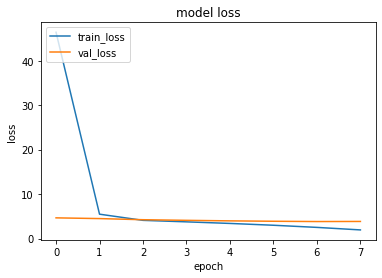

In [23]:
# 모델 결과 출력
plt.plot(history.history["loss"])
plt.plot(history.history["val_mse"])
plt.title("model loss")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend(["train_loss", "val_loss"], loc="upper left")
plt.show()

In [24]:
pred_value = model.predict(test_model_input, 1024)
predict = np.around(pred_value)
answer = test_model_input['TOTAL_RATE']
mean_squared_error(answer, predict)

3.898740710156895

In [ ]:
type(test_model_input)

dict

In [105]:
Final_Train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 48438 entries, 0 to 48437
Data columns (total 53 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   USER_ID            48438 non-null  int64  
 1   HOSPITAL_ID        48438 non-null  int64  
 2   시군구코드              48438 non-null  int64  
 3   진료과목_가정의학과         48438 non-null  int64  
 4   진료과목_결핵과           48438 non-null  int64  
 5   진료과목_구강내과          48438 non-null  int64  
 6   진료과목_구강병리과         48438 non-null  int64  
 7   진료과목_구강악안면외과       48438 non-null  int64  
 8   진료과목_내과            48438 non-null  int64  
 9   진료과목_마취통증의학과       48438 non-null  int64  
 10  진료과목_방사선종양학과       48438 non-null  int64  
 11  진료과목_병리과           48438 non-null  int64  
 12  진료과목_비뇨의학과         48438 non-null  int64  
 13  진료과목_사상체질과         48438 non-null  int64  
 14  진료과목_산부인과          48438 non-null  int64  
 15  진료과목_성형외과          48438 non-null  int64  
 16  진료과목_소아청소년과        484

## 제출파일 만들기

In [ ]:
test

,Unnamed: 0,USER_ID,Question_ID,HOSPITAL_CD,HOSPITAL_NM,ADD,HOSPITAL_ID,TIME,요양기관명,종별코드,...,시도코드명,시군구코드,시군구코드명,전화번호,병원홈페이지(URL),개설일자,총의사수,x좌표,y좌표,Predict_Score
0,1,1034825,1034825_85156,JDQ4MTg4MSM1MSMkMiMkNCMkMDAkNDgxMzUxIzMxIyQxIy...,리팅성형외과의원,서울특별시 강남구 도산대로 119 K타워 5층,85156,2020-09-11 17:19:48,리팅성형외과의원,31,...,서울,110001,강남구,1899-9717,http://www.yonseiplus.com,2016-09-07 00:00:00,25,127.020169,37.515876,1
1,9,201020684119,201020684119_33732,JDQ4MTg4MSM1MSMkMSMkMCMkMTMkNDgxNzAyIzMxIyQxIy...,로담한의원 강남점,"서울특별시 강남구 강남대로 498 3층 (논현동, 명성빌딩)",33732,2019-10-21 00:25:48,로담한의원,93,...,서울,110001,강남구,3444-7523,http://www.skincora.com,2015-10-21 00:00:00,4,127.023893,37.506695,1
2,13,1078855,1078855_203038,JDQ4MTg4MSM1MSMkMiMkNCMkMDAkNTgxMzUxIzMxIyQyIy...,나나성형외과,"서울특별시 강남구 강남대로 492, 지상 2층",203038,2020-01-10 05:12:27,나나성형외과의원,31,...,서울,110001,강남구,02-544-0601,NaN,2018-05-28 00:00:00,20,127.024119,37.506211,1
3,14,1501770,1501770_47123,JDQ4MTg4MSM1MSMkMiMkNCMkMDAkNTgxOTYxIzExIyQxIy...,리스펙성형외과의원,서울특별시 서초구 강남대로 441 서산빌딩 6층 (서초동),47123,2021-06-01 03:56:31,리스펙성형외과의원,31,...,서울,110021,서초구,02-532-0888,NaN,2019-10-31 00:00:00,2,127.025305,37.501747,1
4,16,582814,582814_54799,JDQ4MTg4MSM1MSMkMSMkNCMkMTMkNDgxOTYxIzMxIyQxIy...,자연과한의원 노원점,서울특별시 노원구 동일로 1417 2층,54799,2022-04-12 09:10:37,자연과한의원,93,...,서울,110022,노원구,02-951-1357,NaN,2012-04-05 00:00:00,1,127.059991,37.655041,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1401,3605,1405162,1405162_116235,JDQ4MTg4MSM1MSMkMiMkNCMkMDAkNDgxMTkxIzIxIyQxIy...,시안의원,"서울특별시 서초구 강남대로 439 8층 (서초동, 유화빌딩)",116235,2020-10-24 10:26:53,시안의원,31,...,서울,110021,서초구,534-5555,NaN,2013-10-15 00:00:00,3,127.025402,37.501546,1
1402,3607,1405162,1405162_85781,JDQ4MTg4MSM1MSMkMiMkNCMkMDAkMzgxMTkxIzUxIyQxIy...,재시아성형외과의원,"서울특별시 강남구 선릉로 840, 3층",85781,2020-10-24 10:24:35,재시아성형외과의원,31,...,서울,110001,강남구,3442-1991,http://www.jaessia.com,1999-10-18 00:00:00,1,127.040740,37.526802,1
1403,3609,1405162,1405162_229060,JDQ4MTg4MSM1MSMkMiMkNCMkMDAkNTgxOTYxIzIxIyQxIy...,강남역 데이원의원,서울특별시 서초구 강남대로 423 한승빌딩 4층 402호 (서초동),229060,2020-12-01 10:19:08,강남역데이원의원,31,...,서울,110021,서초구,02-594-5001,NaN,2019-12-03 00:00:00,1,127.025845,37.500259,1
1404,3627,1410677,1410677_76169,JDQ4MTg4MSM1MSMkMiMkNCMkMDAkMzgxMTkxIzMxIyQxIy...,유앤아이의원 영등포점,서울특별시 영등포구 영중로 12 에쉐르빌딩 7층,76169,2021-09-08 04:46:22,유앤아이의원,31,...,서울,110013,영등포구,02-2636-6020,http://www.blueuro.co.kr,2018-10-12 00:00:00,6,126.906519,37.517634,1


In [81]:
Merged_Test = pd.merge(test, Sub_Data, left_on='HOSPITAL_CD',right_on='암호화요양기호',how='left')

In [49]:
Merged_Test[Merged_Test['진료과목코드명'].isna()]

,Unnamed: 0,USER_ID,Question_ID,HOSPITAL_CD,HOSPITAL_NM,ADD,HOSPITAL_ID,TIME,요양기관명,종별코드,...,시군구코드명,전화번호,병원홈페이지(URL),개설일자,총의사수,x좌표,y좌표,Predict_Score,암호화요양기호,진료과목코드명


In [82]:
# Muliti Label Onehot
mlb = MultiLabelBinarizer()
Encoded_Value = mlb.fit_transform(Merged_Test['진료과목코드명'])
Hospital_Class = mlb.classes_
Hospital_Class = ['진료과목'+'_'+ k for k in Hospital_Class]
One_Hot_Classes = pd.DataFrame(Encoded_Value, columns = Hospital_Class)
Merged_Test = Merged_Test.drop('진료과목코드명', axis=1)

Refined_Test = pd.concat([Merged_Test, One_Hot_Classes], axis=1)

In [97]:
# 학습에 활용할 모든 Column
ALL_FIELDS = ['USER_ID','HOSPITAL_ID','시군구코드','x좌표','y좌표']

# 학습에 활용할 모든 Column
Subject_FIELDS = [k for k in Refined_Test.columns if k.startswith('진료과목')]

# 연속형 변수가 담긴 Column
CONT_FIELDS = ['x좌표','y좌표']

# 범주형 변수가 담긴 Column > One Hot Encoding으로 변경해야함
CAT_FIELDS = list(set(ALL_FIELDS).difference(CONT_FIELDS)) + Subject_FIELDS

mms = MinMaxScaler(feature_range=(0,1))
Refined_Test[CONT_FIELDS] = mms.fit_transform(Refined_Test[CONT_FIELDS])

for feat in CAT_FIELDS:
    lbe = LabelEncoder()
    Refined_Test[feat] = lbe.fit_transform(Refined_Test[feat])

fixlen_feature_columns = [SparseFeat(feat, Refined_Test[feat].nunique()) for feat in CAT_FIELDS] + [DenseFeat(feat,1,)for feat in CONT_FIELDS]
dnn_feature_columns = fixlen_feature_columns
linear_feature_columns = fixlen_feature_columns

DeepFM_Test_Columns = get_feature_names(fixlen_feature_columns)
# DeepFM_Test_Columns.append('Predict_Score')

Final_Test = Refined_Test[DeepFM_Test_Columns]
Final_Test[Final_Test.isna().any(axis=1)]

Final_Test = Final_Test.fillna(0)
Final_Test

,USER_ID,HOSPITAL_ID,시군구코드,진료과목_가정의학과,진료과목_결핵과,진료과목_구강내과,진료과목_구강병리과,진료과목_구강악안면외과,진료과목_내과,진료과목_마취통증의학과,...,진료과목_한방부인과,진료과목_한방소아과,진료과목_한방신경정신과,진료과목_한방안·이비인후·피부과,진료과목_한방응급,진료과목_한방재활의학과,진료과목_핵의학과,진료과목_흉부외과,x좌표,y좌표
0,624,529,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0.628586,0.399724
1,1167,215,0,0,0,0,0,0,0,0,...,1,1,1,1,1,1,0,0,0.639677,0.366401
2,751,608,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0.640351,0.364644
3,1077,322,20,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0.643883,0.348439
4,471,376,21,0,0,0,0,0,0,0,...,1,1,1,1,0,1,0,0,0.747203,0.904876
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1401,980,550,20,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0.644173,0.347710
1402,980,539,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0.689858,0.439386
1403,980,631,20,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0.645492,0.343036
1404,989,521,12,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0.290058,0.406108


In [ ]:
Final_Test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1406 entries, 0 to 1405
Data columns (total 52 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   USER_ID            1406 non-null   int64  
 1   시군구코드              1406 non-null   int64  
 2   HOSPITAL_ID        1406 non-null   int64  
 3   진료과목_가정의학과         1406 non-null   int64  
 4   진료과목_결핵과           1406 non-null   int64  
 5   진료과목_구강내과          1406 non-null   int64  
 6   진료과목_구강병리과         1406 non-null   int64  
 7   진료과목_구강악안면외과       1406 non-null   int64  
 8   진료과목_내과            1406 non-null   int64  
 9   진료과목_마취통증의학과       1406 non-null   int64  
 10  진료과목_방사선종양학과       1406 non-null   int64  
 11  진료과목_병리과           1406 non-null   int64  
 12  진료과목_비뇨의학과         1406 non-null   int64  
 13  진료과목_사상체질과         1406 non-null   int64  
 14  진료과목_산부인과          1406 non-null   int64  
 15  진료과목_성형외과          1406 non-null   int64  
 16  진료과목_소아청소년과        1406 

In [ ]:
# test = Final_Test.drop(['Predict_Score'], axis = 1)

In [29]:
device = 'cuda'

model = DeepFM(linear_feature_columns, dnn_feature_columns, task='regression', device=device, dnn_dropout=0.5)

model.compile(optimizer = 'adam',
              loss = 'mse',
              metrics = ['mse'])

In [98]:
test_model_input = {name: Final_Test[name] for name in DeepFM_Test_Columns}

# history = model.fit(test_model_input, Final_Test['Predict_Score'].values, batch_size=1024, epochs=8, verbose=1, validation_split=0.2)
# history = model.fit(train_model_input, train['TOTAL_RATE'].values, batch_size=1024, epochs=8, verbose=1, validation_split=0.2)

In [85]:
Final_Test

,USER_ID,HOSPITAL_ID,시군구코드,진료과목_가정의학과,진료과목_결핵과,진료과목_구강내과,진료과목_구강병리과,진료과목_구강악안면외과,진료과목_내과,진료과목_마취통증의학과,...,진료과목_한방부인과,진료과목_한방소아과,진료과목_한방신경정신과,진료과목_한방안·이비인후·피부과,진료과목_한방응급,진료과목_한방재활의학과,진료과목_핵의학과,진료과목_흉부외과,x좌표,y좌표
0,624,529,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0.628586,0.399724
1,1167,215,0,0,0,0,0,0,0,0,...,1,1,1,1,1,1,0,0,0.639677,0.366401
2,751,608,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0.640351,0.364644
3,1077,322,20,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0.643883,0.348439
4,471,376,21,0,0,0,0,0,0,0,...,1,1,1,1,0,1,0,0,0.747203,0.904876
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1401,980,550,20,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0.644173,0.347710
1402,980,539,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0.689858,0.439386
1403,980,631,20,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0.645492,0.343036
1404,989,521,12,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0.290058,0.406108


In [99]:
pred_value = model.predict(test_model_input, 1024)
predict = np.around(pred_value)

In [100]:
predict

array([[7.],
       [8.],
       [6.],
       ...,
       [8.],
       [8.],
       [7.]])

In [101]:
submission['Predict_Score'] = predict

In [102]:
submission.Predict_Score.value_counts()

8.0     566
7.0     410
9.0     266
6.0     122
10.0     39
5.0       3
Name: Predict_Score, dtype: int64

In [104]:
submission.to_csv('first_baseline.csv')

## LGBM 추가 앙상블 모델로서 학습하기?



In [ ]:
for k in CAT_FIELDS:
    Final_Train[k]=Final_Train[k].astype('category')
    
lgbm_train_columns = get_feature_names(fixlen_feature_columns)    
    
X_train, X_test, y_train, y_test = train_test_split(Final_Train[lgbm_train_columns],Final_Train['TOTAL_RATE'] ,test_size=0.2, random_state=156)

In [ ]:
lgbm_wrapper = LGBMRegressor(n_estimators=400)
evals = [(X_test, y_test)]
lgbm_wrapper.fit(X_train, y_train, early_stopping_rounds=100, eval_metric='mae', eval_set=evals, verbose=True)

[1]	valid_0's l1: 1.65908	valid_0's l2: 4.43795
Training until validation scores don't improve for 100 rounds.
[2]	valid_0's l1: 1.62981	valid_0's l2: 4.31954
[3]	valid_0's l1: 1.60373	valid_0's l2: 4.22415
[4]	valid_0's l1: 1.58055	valid_0's l2: 4.14681
[5]	valid_0's l1: 1.55952	valid_0's l2: 4.0836
[6]	valid_0's l1: 1.54074	valid_0's l2: 4.03188
[7]	valid_0's l1: 1.52416	valid_0's l2: 3.98953
[8]	valid_0's l1: 1.50959	valid_0's l2: 3.95493
[9]	valid_0's l1: 1.49804	valid_0's l2: 3.92867
[10]	valid_0's l1: 1.48749	valid_0's l2: 3.90626
[11]	valid_0's l1: 1.47791	valid_0's l2: 3.88674
[12]	valid_0's l1: 1.47004	valid_0's l2: 3.87358
[13]	valid_0's l1: 1.46299	valid_0's l2: 3.86158
[14]	valid_0's l1: 1.45665	valid_0's l2: 3.85057
[15]	valid_0's l1: 1.45117	valid_0's l2: 3.84308
[16]	valid_0's l1: 1.44563	valid_0's l2: 3.83292
[17]	valid_0's l1: 1.44083	valid_0's l2: 3.82495
[18]	valid_0's l1: 1.43637	valid_0's l2: 3.81728
[19]	valid_0's l1: 1.43265	valid_0's l2: 3.81321
[20]	valid_0's l

LGBMRegressor(n_estimators=400)

In [ ]:
pred = lgbm_wrapper.predict(X_test)
mean_squared_error(pred,y_test.values)

3.7372123813648885

### 위에 사용한 Tree Model들의 Hyper Parameter는 설정하기 귀찮고 힘든데 Optuna로 설정해보는 것에 목적

In [ ]:
import matplotlib.font_manager as fm

In [ ]:
!apt -qq -y install fonts-nanum > /dev/null

In [ ]:

fm.get_fontconfig_fonts()
font_location = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'
font_name = fm.FontProperties(fname=font_location).get_name()


In [ ]:
plt.rc('font', family=font_name)
print(plt.rcParams['font.family'])

['NanumBarunGothic']


/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 51652 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 47308 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 44284 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 47785 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 54620 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 48169 missing from current font.
  font.set_

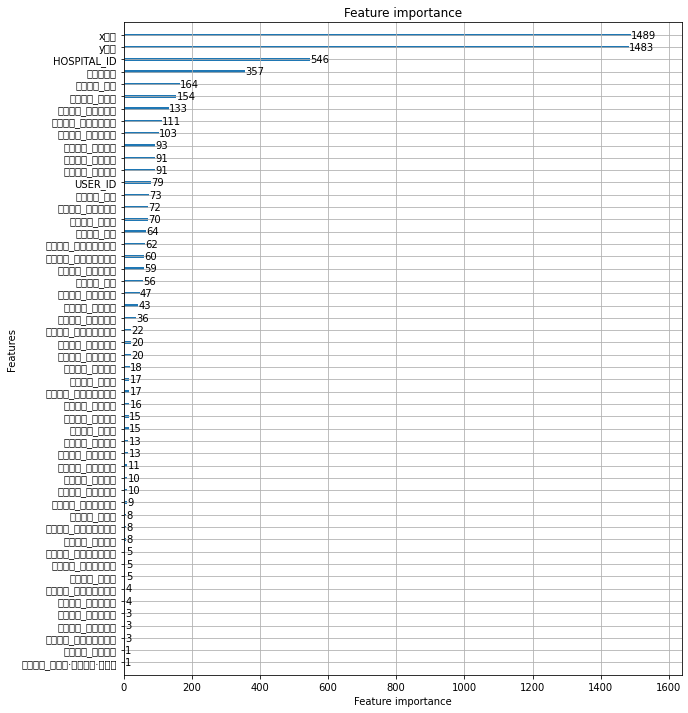

In [ ]:
fig, ax = plt.subplots(figsize=(10,12))
plot_importance(lgbm_wrapper, ax=ax)
plt.show()

### Optuna로 Tuning

In [ ]:
import optuna
from optuna import Trial, visualization
from optuna.samplers import TPESampler

In [ ]:
sampler = TPESampler(seed=10) # 젤 많이 쓰이는 sampler, DL에서 optimizer 느낌

def objective(trial):
    dtrain = Dataset(X_train, label=y_train)
    dtest = Dataset(X_test, label=y_test)

    param = {
        'objective': 'regression', # 회귀
        'verbose': -1,
        'metric': 'rmse', 
        'max_depth': trial.suggest_int('max_depth',3, 30),        # suggest_int 정수로 이동하면서 학습
        'learning_rate': trial.suggest_loguniform("learning_rate", 1e-8, 1e-2), # suggest_loguniform 함수를 써 줘야 소수점을 따라 학습
        'n_estimators': trial.suggest_int('n_estimators', 100, 3000),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
        'subsample': trial.suggest_loguniform('subsample', 0.4, 1),
    }

    model = LGBMRegressor(**param) # ** = 가변적이라는 뜻
    lgb_model = model.fit(X_train, y_train, eval_set=[(X_test, y_test)], verbose=0, early_stopping_rounds=25)
    mse = mean_squared_error(y_test, lgb_model.predict(X_test))
    return mse
        
study_lgb = optuna.create_study(direction='minimize', sampler=sampler)
study_lgb.optimize(objective, n_trials=100)

[I 2022-12-05 08:13:21,799] A new study created in memory with name: no-name-d358813c-3d41-47d4-8840-3bda7f472a13
<ipython-input-66-833ad3f29d7a>:12: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate': trial.suggest_loguniform("learning_rate", 1e-8, 1e-2), # suggest_loguniform 함수를 써 줘야 소수점을 따라 학습
<ipython-input-66-833ad3f29d7a>:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'subsample': trial.suggest_loguniform('subsample', 0.4, 1),
[I 2022-12-05 08:13:42,645] Trial 0 finished with value: 4.583790286230395 and parameters: {'max_depth': 24, 'learning_rate': 1.3320229150659043e-08, 'n_estimators': 1938, 'min_child_samples': 76, 'sub

### 위 코드에서 파라미터 추출하고 추가 학습까지 진행해 줘야 함

In [ ]:
trial_params = {'max_depth': 23, 'learning_rate': 0.00990323848202835, 'n_estimators': 846, 'min_child_samples': 24, 'subsample': 0.8701277798440029}

In [ ]:
final_lgb_model = LGBMRegressor(**trial_params)
final_lgb_model.fit(X_train, y_train)
final_lgb_pred = final_lgb_model.predict(X_test)

NameError: ignored

In [ ]:
mean_squared_error(final_lgb_pred,y_test.values)

3.751720646556697

In [ ]:
X_train

,시군구코드,HOSPITAL_ID,USER_ID,진료과목_X,진료과목_가정의학과,진료과목_결핵과,진료과목_구강내과,진료과목_구강병리과,진료과목_구강악안면외과,진료과목_내과,...,진료과목_한방부인과,진료과목_한방소아과,진료과목_한방신경정신과,진료과목_한방안·이비인후·피부과,진료과목_한방응급,진료과목_한방재활의학과,진료과목_핵의학과,진료과목_흉부외과,x좌표,y좌표
45385,21,2026,1910,0,1,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0.244242,0.962994
14395,16,5452,40126,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0.211985,0.943247
23897,0,5484,15701,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0.224997,0.933068
36754,0,36,22387,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0.225234,0.932880
11887,0,5592,21832,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0.226680,0.930510
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6955,0,5504,41265,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0.225427,0.932730
7653,0,1166,36075,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0.225427,0.932730
42402,15,1832,3651,0,1,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0.202400,0.945857
39628,22,417,24814,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0.249106,0.939076


In [ ]:

# Final_Train['Q_ID'] 
cols = ['USER_ID', 'HOSPITAL_ID']
Final_Train['Q_ID'] = Final_Train[cols].apply(lambda x : '_'.join(x.values.astype(str)), axis=1)

In [ ]:
Final_Train

,시군구코드,HOSPITAL_ID,USER_ID,진료과목_X,진료과목_가정의학과,진료과목_결핵과,진료과목_구강내과,진료과목_구강병리과,진료과목_구강악안면외과,진료과목_내과,...,진료과목_한방신경정신과,진료과목_한방안·이비인후·피부과,진료과목_한방응급,진료과목_한방재활의학과,진료과목_핵의학과,진료과목_흉부외과,x좌표,y좌표,TOTAL_RATE,Q_ID
0,0,5420,6201,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0.225242,0.932660,9.0,6201_5420
1,0,5420,37701,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0.225242,0.932660,10.0,37701_5420
2,0,5420,3855,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0.225242,0.932660,10.0,3855_5420
3,0,5420,37634,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0.225242,0.932660,5.0,37634_5420
4,0,5420,6739,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0.225242,0.932660,10.0,6739_5420
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48433,22,4961,36589,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0.244066,0.936719,8.0,36589_4961
48434,24,5065,33045,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0.183371,0.924642,6.0,33045_5065
48435,18,5406,36599,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0.000000,0.000000,10.0,36599_5406
48436,20,1753,36613,0,0,0,0,0,0,0,...,1,1,0,1,0,0,0.243586,0.919438,10.0,36613_1753


In [ ]:
Final_Train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 48438 entries, 0 to 48437
Data columns (total 56 columns):
 #   Column             Non-Null Count  Dtype   
---  ------             --------------  -----   
 0   시군구코드              48438 non-null  category
 1   HOSPITAL_ID        48438 non-null  category
 2   USER_ID            48438 non-null  category
 3   진료과목_X             48438 non-null  category
 4   진료과목_가정의학과         48438 non-null  category
 5   진료과목_결핵과           48438 non-null  category
 6   진료과목_구강내과          48438 non-null  category
 7   진료과목_구강병리과         48438 non-null  category
 8   진료과목_구강악안면외과       48438 non-null  category
 9   진료과목_내과            48438 non-null  category
 10  진료과목_마취통증의학과       48438 non-null  category
 11  진료과목_방사선종양학과       48438 non-null  category
 12  진료과목_병리과           48438 non-null  category
 13  진료과목_비뇨기과          48438 non-null  category
 14  진료과목_비뇨의학과         48438 non-null  category
 15  진료과목_사상체질과         48438 non-null  category
 16  진료과목

In [ ]:
Final_Train[Final_Train['Q_ID'] == '582814_54799']

,시군구코드,HOSPITAL_ID,USER_ID,진료과목_X,진료과목_가정의학과,진료과목_결핵과,진료과목_구강내과,진료과목_구강병리과,진료과목_구강악안면외과,진료과목_내과,...,진료과목_한방신경정신과,진료과목_한방안·이비인후·피부과,진료과목_한방응급,진료과목_한방재활의학과,진료과목_핵의학과,진료과목_흉부외과,x좌표,y좌표,TOTAL_RATE,Q_ID


In [ ]:
pred

,Question_ID,Predict_Score
0,1034825_85156,1
1,201020684119_33732,1
2,1078855_203038,1
3,1501770_47123,1
4,582814_54799,1
...,...,...
1401,1405162_116235,1
1402,1405162_85781,1
1403,1405162_229060,1
1404,1410677_76169,1


In [ ]:
optuna.visualization.plot_param_importances(study_lgb)